In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-dialog-corpus/movie_characters_metadata.tsv
/kaggle/input/movie-dialog-corpus/raw_script_urls.tsv
/kaggle/input/movie-dialog-corpus/movie_titles_metadata.tsv
/kaggle/input/movie-dialog-corpus/movie_lines.tsv
/kaggle/input/movie-dialog-corpus/README.txt
/kaggle/input/movie-dialog-corpus/movie_conversations.tsv


In [2]:
# 📦 Import Required Libraries
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 📂 Load movie_lines.txt
with open("/kaggle/input/movie-dialog-corpus/movie_lines.tsv", encoding='utf-8', errors='ignore') as file:
    lines = file.readlines()

# 🧹 Extract Dialogues (5th field from each line)
dialogues = [line.split(" +++$+++ ")[-1].strip() for line in lines]

# 🔽 Optional: Limit to first 10000 lines
dialogues = dialogues[:10000]

# ✅ Clean Text Function (removes punctuation, tabs, single chars like "l", "u", "m")
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)         # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra spaces/tabs
    words = text.split()
    words = [word for word in words if len(word) > 1 or word in ['a', 'i']]  # keep 'a' and 'i'
    return ' '.join(words)

# 🧹 Apply cleaning to each dialogue line
corpus = [clean_text(line) for line in dialogues if len(line.split()) > 3]

# 🔍 Check one cleaned line
print("Sample cleaned sentence:\n", corpus[0])

# 🧠 Tokenize the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print("\nTotal unique words:", total_words)

# 🔁 Create Input Sequences (n-gram based)
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

# ⏩ Pad Sequences
max_seq_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# 🎯 Prepare Inputs and Labels
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

# ✅ Final Check
print("\nX shape:", X.shape)
print("y shape:", y.shape)
print("Max sequence length:", max_seq_len)


2025-06-16 17:04:57.713347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750093497.928353      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750093497.993047      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sample cleaned sentence:
 bianca they do not

Total unique words: 8499

X shape: (100812, 202)
y shape: (100812, 8499)
Max sequence length: 203


In [3]:
# 🔧 Import Required Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 🧠 Define the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_seq_len - 1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

# ⚙️ Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🏋️ Train the Model
early_stop = EarlyStopping(monitor='loss', patience=2)
history = model.fit(X, y, epochs=60, batch_size=256, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1750093528.035419      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750093528.036236      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/60


I0000 00:00:1750093545.299649     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


394/394 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.0396 - loss: 6.9948
Epoch 2/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.0574 - loss: 6.2096
Epoch 3/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.0803 - loss: 5.8717
Epoch 4/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.1033 - loss: 5.6167
Epoch 5/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.1158 - loss: 5.4367
Epoch 6/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.1271 - loss: 5.2543
Epoch 7/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.1351 - loss: 5.1121
Epoch 8/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.1422 - loss: 4.9859
Epoch 9/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.1496 - loss: 4.8581
Epoch 10/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.1586 - loss: 4.7374
Epoch 11/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.1639 - loss: 4.6243
Epoch 12/60
394/394 ━━━━━━━━━━━━━━━━━━━━ 

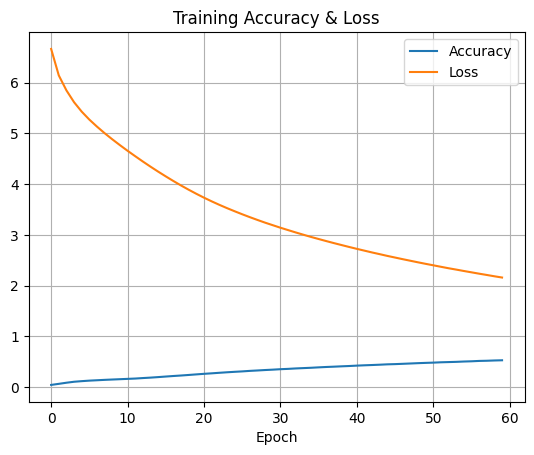

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'])
plt.grid()
plt.show()


In [5]:
def predict_next_words(seed_text, next_words=10):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_id = np.argmax(predicted_probs, axis=1)[0]

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                output_word = word
                break

        seed_text += " " + output_word
    return seed_text


In [7]:
print(predict_next_words("bianca they do", next_words=1))
print(predict_next_words("i am not", next_words=1))
print(predict_next_words("what are you", next_words=1))


bianca they do to
i am not food
what are you doing


In [8]:
# 📂 Load full movie_lines.txt
with open("/kaggle/input/movie-dialog-corpus/movie_lines.tsv", encoding='utf-8', errors='ignore') as file:
    lines = file.readlines()

# 🧹 Extract dialogues
dialogues = [line.split(" +++$+++ ")[-1].strip() for line in lines]

# ✅ Clean and filter
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

# 🔁 Use full dataset now (not [:10000])
corpus = [clean_text(line) for line in dialogues if len(line.split()) > 3]
print("Total sentences:", len(corpus))


Total sentences: 304713


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# 🔍 Custom Bahdanau Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        self.V = self.add_weight(name="att_v", shape=(input_shape[-1], 1), initializer="random_normal")
        super(Attention, self).build(input_shape)

    def call(self, hidden_states):
        # hidden_states: [batch, time, features]
        score = tf.nn.tanh(tf.tensordot(hidden_states, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# 🧠 Define Model with Attention
input_layer = Input(shape=(max_seq_len - 1,))
embedding_layer = Embedding(input_dim=total_words, output_dim=100)(input_layer)
lstm_out = Bidirectional(LSTM(150, return_sequences=True))(embedding_layer)
attention_output = Attention()(lstm_out)
output_layer = Dense(total_words, activation='softmax')(attention_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 202)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 202, 100)            │         849,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 202, 300)            │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 300)                 │          90,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8499)                │       2,558,199 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,799,899 (14.50 MB)

 Trainable params: 3,799,899 (14.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ⏱️ Train for fewer epochs initially (to test)
model.fit(X, y, batch_size=256, epochs=30)


Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.0390 - loss: 6.9890
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.0526 - loss: 6.2871
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.0602 - loss: 6.0735
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.0687 - loss: 5.9114
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.0825 - loss: 5.7519
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.0979 - loss: 5.6074
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.1092 - loss: 5.4667
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.1204 - loss: 5.3133
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.1281 - loss: 5.1734
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.1372 - loss: 5.0495
Epoch 11/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.1438 - loss: 4.9101
Epoch 12/30
394/394 ━━━━━━━━━━

In [11]:
def predict_next_words(seed_text, next_words=10):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_id = np.argmax(predicted_probs, axis=1)[0]

        output_word = tokenizer.index_word.get(predicted_id, '')
        if output_word:
            seed_text += " " + output_word
    return seed_text.capitalize()



In [13]:
print(predict_next_words("i dont know", next_words=1))
print(predict_next_words("what are you", next_words=2))
print(predict_next_words("they are coming", next_words=3))


I dont know what
What are you doing here
They are coming back at the
